In [210]:
import scipy.spatial
import math
import numpy
import tqdm
import matplotlib.pyplot as pl
import random

In [243]:
def exclude(lst, idx):
    return lst[:idx] + lst[idx+1:]
def noised(data, level):
    out = data.copy()
    for x in range(out.shape[1]):
        for y in range(out.shape[0]): 
            if random.randint(0, 100) <= level:
                out[y, x] = {0: 1, 1: 0}[data[y, x]]
    return numpy.array(out, dtype=numpy.uint8)
def reshape(data):
    W = data.shape[0]
    w = math.sqrt(W)
    w = int(w)
    h = W // w
    return data.reshape(w, h)
def show(data, pl=pl):
    if len(data) == 1:
        data = reshape(data)
    pl.imshow(data, cmap='gray')
def grid(array, ncols=4, pad=2):
    if isinstance(array, list):
        array = map(lambda x: reshape(x) if len(x.shape) == 1 else x, array)
        array = numpy.array([numpy.pad(x, pad) for x in array])
    nindex, height, width = array.shape
    nrows = nindex//ncols
    result = (array.reshape(nrows, ncols, height, width, 1)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols, 1))
    return result

In [142]:
a = numpy.array([
        0, 0, 1, 1, 1, 0,
        0, 1, 0, 0, 1, 0,
        0, 0, 0, 1, 0, 0,
        0, 0, 1, 0, 0, 0,
        0, 1, 0, 0, 0, 0,
        1, 1, 1, 1, 1, 0,
])

b = numpy.array([
        0, 0, 1, 1, 1, 0,
        0, 1, 0, 0, 1, 0,
        0, 0, 0, 1, 0, 0,
        0, 0, 0, 1, 0, 0,
        0, 1, 0, 0, 1, 0,
        0, 0, 1, 1, 1, 0,
])

c = numpy.array([
        0, 1, 0, 0, 1, 0,
        0, 1, 0, 0, 1, 0,
        0, 1, 0, 0, 1, 0,
        0, 1, 1, 1, 1, 0,
        0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 0,
])

d = numpy.array([
        0, 1, 1, 1, 1, 0,
        0, 1, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 0,
        0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 0,
        0, 1, 1, 1, 1, 0,
])

e = numpy.array([
        1, 1, 1, 1, 1, 0,
        0, 0, 0, 0, 1, 0,
        0, 0, 0, 1, 0, 0,
        0, 0, 1, 0, 0, 0,
        0, 1, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0,
])

ff = numpy.array([
        0, 0, 0, 1, 0, 0,
        0, 0, 1, 1, 0, 0,
        0, 0, 0, 1, 0, 0,
        0, 0, 0, 1, 0, 0,
        0, 0, 0, 1, 0, 0,
        0, 0, 1, 1, 1, 0,
])
golden = [a, b, c, d, e, ff]
answers = [numpy.pad([1], (x, len(golden)-x-1)) for x in range(0, len(golden))]
labels = ['a','b','c','d','e', 'f']

In [270]:
class Rbf:
    def __init__(self, ilen, hlen, olen, lr):
        # learing rate
        self.lr = lr
        # input values
        self.i = numpy.zeros((hlen, ilen))
        # values 
        self.h = numpy.zeros(hlen)
        # std
        self.s = numpy.zeros(hlen)
        # out values
        self.o = numpy.zeros(olen)
        # weights
        self.w = (numpy.random.rand(olen, hlen) - 0.5) * 2
        
    def update_std(self, inps):
        for i, x in enumerate(inps):
            X = exclude(inps, i)
            Y = list(map(lambda q: scipy.spatial.distance.euclidean(q, x), X))
            self.s[i] = min(Y)
            self.i[i] = x
            
    def predict(self, inp):
        for i in range(self.h.shape[0]):
            X = self.i[i]
            H = self.s[i]
            self.h[i] = math.exp(-((scipy.spatial.distance.euclidean(inp, X) / H) ** 2))
        for i in range(self.o.shape[0]):
            W = self.w[i]
            Y = numpy.multiply(W, self.h)
            self.o[i] = sum(Y)
        return self.o
    
    def fit(self, X, Y):
        Yp = self.predict(X)
        loss = numpy.subtract(Y, self.o)
        for i in range(self.o.shape[0]):
            for j in range(self.h.shape[0]):
                self.w[i, j] += self.lr * loss[i] * self.h[j]
        return numpy.amax(loss)

100%|███████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 427.12it/s]


0.0 2.5220875581273
0.0 2.5220875581273
0.0 2.5220875581273
0.0 2.5220875581273
0.0 2.5220875581273
0.0 2.5220875581273


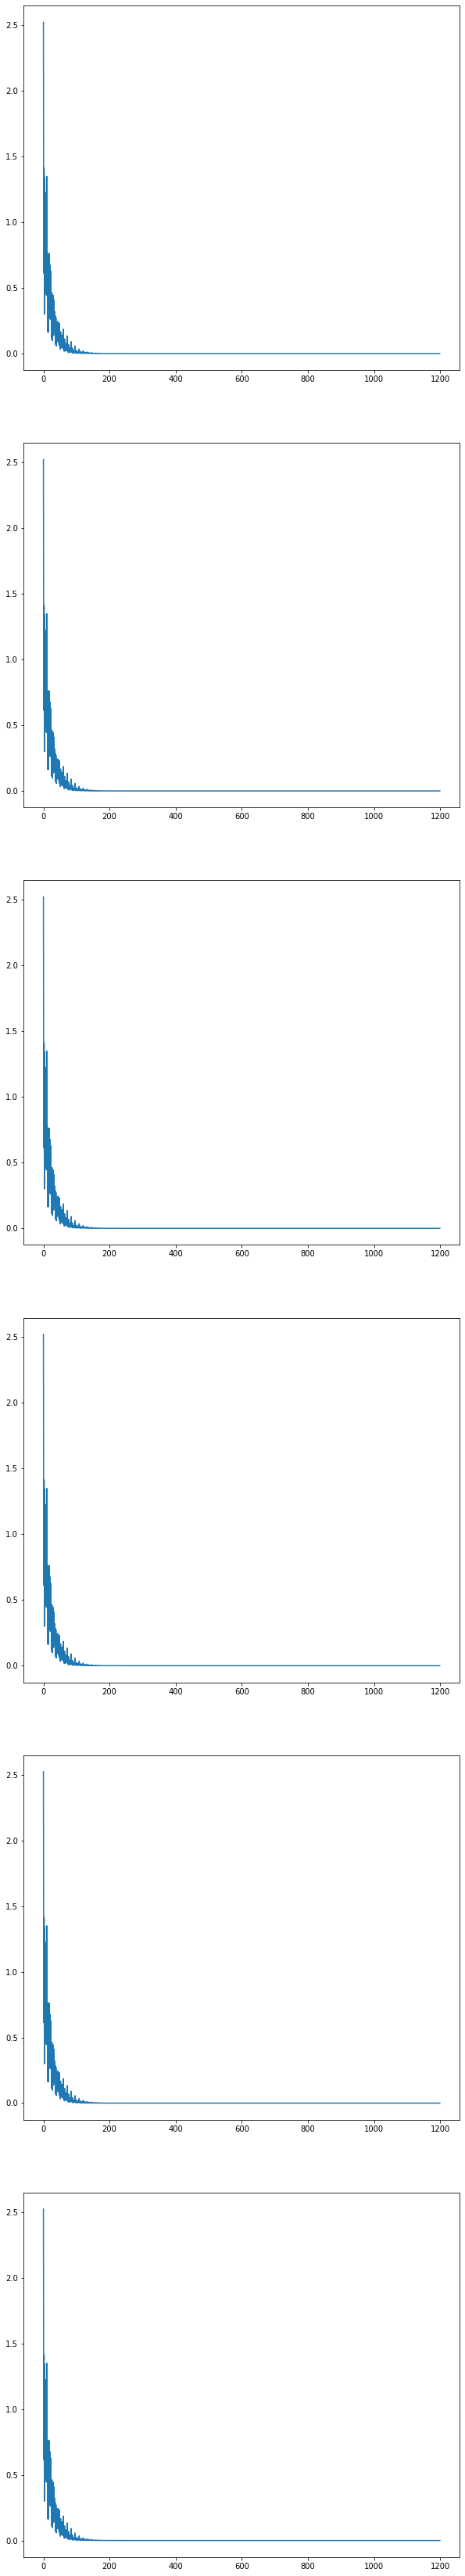

In [332]:
losses = [[]] * len(golden)
model = Rbf(36, 6, 6, 0.5)
model.update_std(golden)
for _ in tqdm.tqdm(range(100)):
    for i, (X,Y) in enumerate(zip(golden, answers)):
        for _ in range(2):
            x = model.fit(golden[i], answers[i])
            losses[i] += [x]
fix, ax = pl.subplots(len(golden), 1, figsize=(10, 10 * len(golden)))
for i in range(len(losses)):
    print(min(losses[i]), max(losses[i]))
    ax[i].plot(losses[i])

In [333]:
def demo(X, Y):
    rs = []
    for l in range(0, 100, 10):
        Xr = noised(reshape(X), l)
        Yp = model.predict(Xr.reshape(36))
        Ym = Yp.max()
        Yi = list(Yp).index(Ym)
        print('%3d %5r: %s with %.2f' % (l, Y == labels[Yi], labels[Yi], Ym))
        rs.append(Xr)
    pl.imshow(grid(rs, 5))

  0  True: a with 0.49
 10  True: a with 0.41
 20  True: a with 0.23
 30 False: d with 0.28
 40 False: c with 0.10
 50 False: c with 0.22
 60 False: f with 0.10
 70 False: c with 0.09
 80 False: c with 0.16
 90 False: c with 0.12


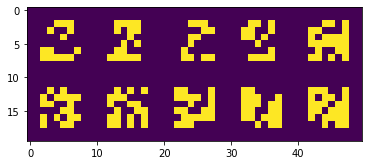

In [334]:
demo(a, 'a')

  0  True: b with 1.00
 10  True: b with 0.33
 20 False: c with 0.20
 30 False: c with 0.20
 40 False: c with 0.18
 50 False: c with 0.21
 60 False: c with 0.19
 70 False: c with 0.09
 80 False: c with 0.09
 90 False: c with 0.11


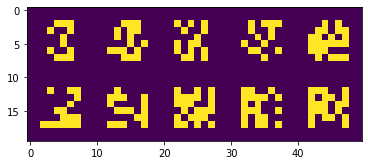

In [335]:
demo(b, 'b')

  0  True: c with 0.92
 10  True: c with 0.61
 20  True: c with 0.48
 30  True: c with 0.34
 40  True: c with 0.18
 50  True: c with 0.19
 60 False: f with 0.19
 70 False: e with 0.08
 80 False: f with 0.15
 90 False: f with 0.10


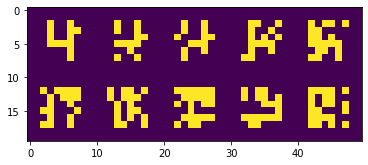

In [336]:
demo(c, 'c')

  0  True: d with 1.00
 10  True: d with 0.69
 20  True: d with 0.39
 30 False: c with 0.16
 40 False: f with 0.14
 50 False: f with 0.07
 60 False: f with 0.15
 70 False: c with 0.29
 80 False: c with 0.10
 90 False: c with 0.11


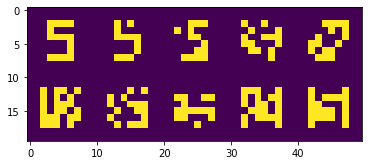

In [337]:
demo(d, 'd')

  0  True: e with 1.00
 10  True: e with 0.47
 20  True: e with 0.41
 30 False: f with 0.18
 40  True: e with 0.29
 50 False: c with 0.12
 60 False: c with 0.13
 70 False: c with 0.23
 80 False: f with 0.09
 90 False: c with 0.12


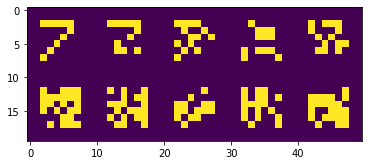

In [338]:
demo(e, 'e')

  0  True: f with 0.80
 10  True: f with 0.90
 20  True: f with 0.30
 30  True: f with 0.15
 40  True: f with 0.13
 50  True: f with 0.18
 60 False: c with 0.17
 70 False: c with 0.15
 80 False: c with 0.16
 90 False: c with 0.19


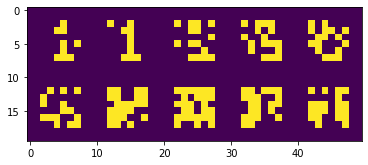

In [339]:
demo(ff, 'f')

In [340]:
def sapmples_test(cnt=1000):
    rs = {}
    dt = list(zip(golden, labels))
    fig, ax = pl.subplots(10, 1, figsize=(10, 50))
    for l in range(0, 100, 10):
        if l not in rs.keys():
            rs[l] = []
        for _ in range(cnt):
            X, Y = random.choice(dt)
            Xr = noised(reshape(X), l)
            Yp = model.predict(Xr.reshape(36))
            Ym = Yp.max()
            Yi = list(Yp).index(Ym)
            R = Ym if Y == labels[Yi] else 0.0
            rs[l].append(R)
    for i, (k, v) in enumerate(rs.items()):
        ax[i].set_title('Noise level: %d ' % (k))
        ax[i].plot(v)

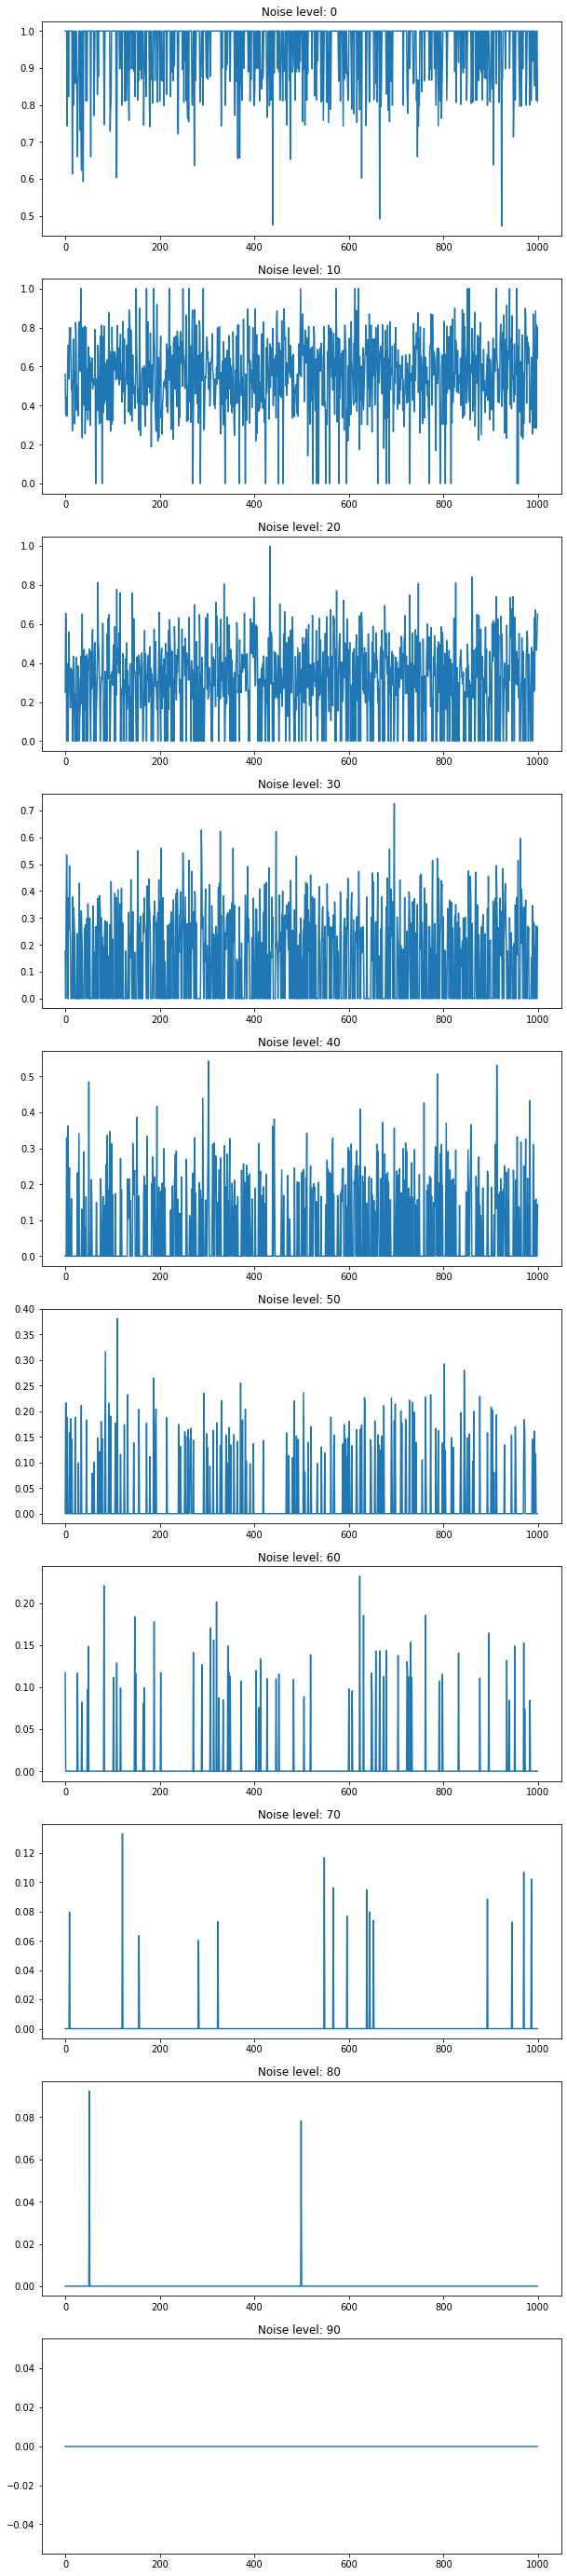

In [342]:
sapmples_test()

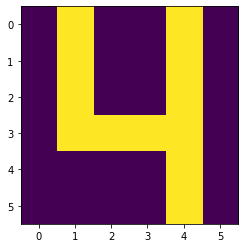

In [311]:
pl.imshow(reshape(c))

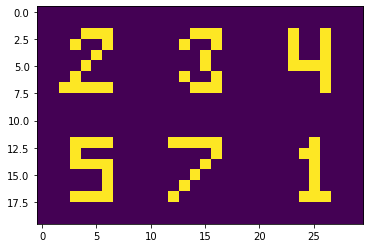

In [330]:
pl.imshow(grid(golden, 3))